Enter the path to your Excel file (with GS3M and GS6M columns): /content/Table 22.7 (1).xlsx


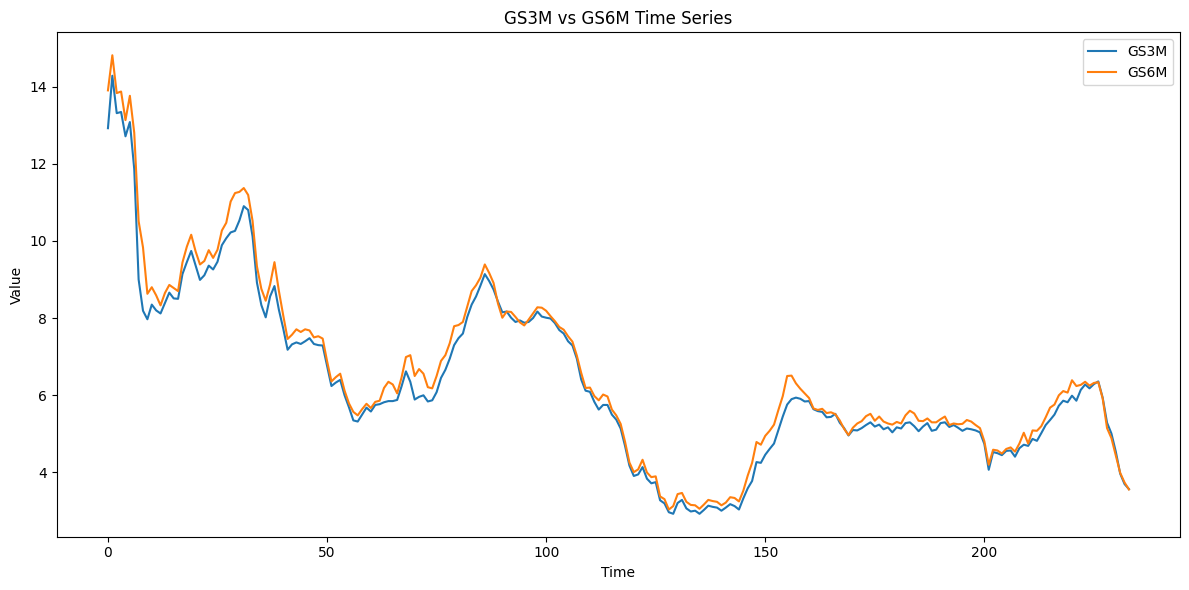


ADF Test for GS3M:
------------------------------
ADF Statistic: -1.5392
p-value: 0.5140
Critical Value 1%: -3.4600
Critical Value 5%: -2.8746
Critical Value 10%: -2.5737
Result: GS3M is NOT stationary (fail to reject null hypothesis).

ADF Test for GS6M:
------------------------------
ADF Statistic: -3.7738
p-value: 0.0032
Critical Value 1%: -3.4589
Critical Value 5%: -2.8741
Critical Value 10%: -2.5735
Result: GS6M is stationary (reject null hypothesis of unit root).

Cointegration Test (Engle-Granger):
------------------------------
Test Statistic: -4.7367
p-value: 0.0005
Result: The series are cointegrated (reject null of no cointegration).

At least one series is not stationary. Differencing both series for VAR model...

Selected lag order for VAR (by AIC): 3

VAR Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 13, Jun, 2025
Time:                     18:35:38
-----------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
<ipython-input-5-1322659499>:79: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df_var.index[-1], periods=5+1, freq='M')[1:]


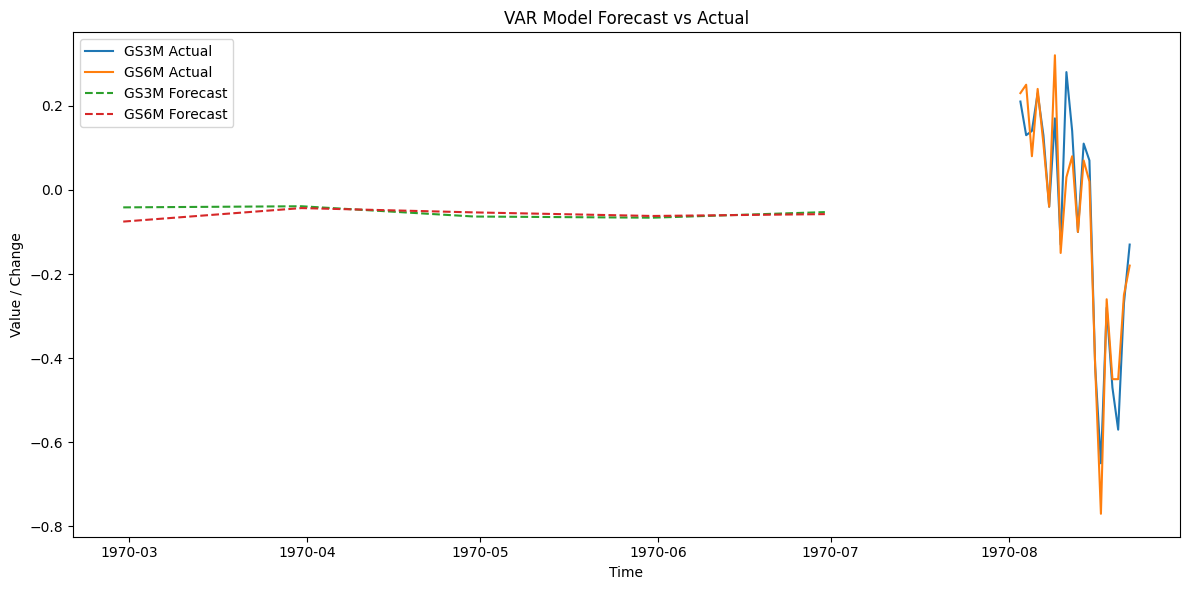

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.api import VAR

# 1. Ask user for the xlsx file path
file_path = input("Enter the path to your Excel file (with GS3M and GS6M columns): ").strip()
df = pd.read_excel(file_path)

# Ensure columns GS3M, GS6M exist
if not {'GS3M', 'GS6M'}.issubset(df.columns):
    raise ValueError("File must contain 'GS3M' and 'GS6M' columns.")

# If there's a date column, parse it and set as index
possible_date_cols = [col for col in df.columns if 'date' in col.lower()]
if possible_date_cols:
    df[possible_date_cols[0]] = pd.to_datetime(df[possible_date_cols[0]])
    df.set_index(possible_date_cols[0], inplace=True)

# 2. Plot the two time series
plt.figure(figsize=(12, 6))
plt.plot(df['GS3M'], label='GS3M')
plt.plot(df['GS6M'], label='GS6M')
plt.title('GS3M vs GS6M Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Unit Root Test (ADF)
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\nADF Test for {name}:")
    print("-" * 30)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print(f"Result: {name} is stationary (reject null hypothesis of unit root).")
        return True
    else:
        print(f"Result: {name} is NOT stationary (fail to reject null hypothesis).")
        return False

gs3m_stationary = adf_test(df['GS3M'], 'GS3M')
gs6m_stationary = adf_test(df['GS6M'], 'GS6M')

# 4. Cointegration Test (Engle-Granger)
score, pvalue, _ = coint(df['GS3M'], df['GS6M'])
print("\nCointegration Test (Engle-Granger):")
print("-" * 30)
print(f"Test Statistic: {score:.4f}")
print(f"p-value: {pvalue:.4f}")
if pvalue < 0.05:
    print("Result: The series are cointegrated (reject null of no cointegration).")
else:
    print("Result: The series are NOT cointegrated (fail to reject null of no cointegration).")

# 5. Prepare data for VAR (difference if not stationary)
df_var = df[['GS3M', 'GS6M']].dropna().copy()
if not gs3m_stationary or not gs6m_stationary:
    print("\nAt least one series is not stationary. Differencing both series for VAR model...")
    df_var = df_var.diff().dropna()

# 6. Fit VAR model
model = VAR(df_var)
lag_order = model.select_order(maxlags=12)
selected_lag = lag_order.selected_orders['aic']  # you can also use bic or fpe
print(f"\nSelected lag order for VAR (by AIC): {selected_lag}")

var_result = model.fit(selected_lag)
print("\nVAR Summary:")
print(var_result.summary())

# 7. Forecast example (next 5 periods)
forecast = var_result.forecast(df_var.values[-selected_lag:], steps=5)
forecast_index = pd.date_range(start=df_var.index[-1], periods=5+1, freq='M')[1:]
forecast_df = pd.DataFrame(forecast, columns=['GS3M_forecast', 'GS6M_forecast'], index=forecast_index)
print("\nVAR Model 5-step Forecast:")
print(forecast_df)

# 8. Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(df_var['GS3M'][-20:], label='GS3M Actual')
plt.plot(df_var['GS6M'][-20:], label='GS6M Actual')
plt.plot(forecast_df['GS3M_forecast'], '--', label='GS3M Forecast')
plt.plot(forecast_df['GS6M_forecast'], '--', label='GS6M Forecast')
plt.title('VAR Model Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Value / Change')
plt.legend()
plt.tight_layout()
plt.show()